# TUTORIAL W36

In this tutorial, we will get acquainted with working with MEG data on UCloud  
We will be using the MNE-sample-data that contains visual and auditory stimulations  
The dataset also contains anatomical MR-data processed with FreeSurfer, meaning that we have access to a forward model linking the source space to sensor space.  
With that we can create an inverse model for reconstructing the sensor space visual and auditory responses in the source space.  
In this tutorial we will zoom through a lot of the steps, which throughout the course will be covered explicitly

## SETUP YOUR ENVIRONMENT

**Make sure that you have followed the instructions for setting up your environment, local and UCloud before beginning on this.** The instructions can be found here: https://github.com/ualsbombe/2025_advanced_cognitive_neuroscience/blob/main/README.md

## RESPECT EACH OTHER'S PERSONAL DATA

**Note** that 3D plots cannot be opened on UCloud (these are mostly (fancy) source space plots). That is why we also set up a local environment for you to create these plots. It is very important that you do **not** store any subject MR-data locally. Therefore, we will only plot on the *fsaverage* template brain (distributed with FreeSurfer). Single subjects can be morphed onto this template

In [2]:
## IMPORTS

import mne ## MNE-Python for analysing data
## below magic provides interactive plots in notebook
%matplotlib widget
from os import chdir
from os.path import join
import matplotlib.pyplot as plt ## for basic plotting
import matplotlib as mpl ## for setting default parameters

In [3]:
#%% SET DEFAULT PLOTTING PARAMETERS

mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['font.size'] = 24
mpl.rcParams['font.weight'] = 'bold'
mpl.rcParams['lines.linewidth'] = 3

## SAMPLE DATA SET (https://mne.tools/stable/documentation/datasets.html#sample)
*These data were acquired with the Neuromag Vectorview system at MGH/HMS/MIT Athinoula A. Martinos Center Biomedical Imaging. EEG data from a 60-channel electrode cap was acquired simultaneously with the MEG. The original MRI data set was acquired with a Siemens 1.5 T Sonata scanner using an MPRAGE sequence.*

*In this experiment, checkerboard patterns were presented to the subject into the left and right visual field, interspersed by tones to the left or right ear. The interval between the stimuli was 750 ms. Occasionally a smiley face was presented at the center of the visual field. The subject was asked to press a key with the right index finger as soon as possible after the appearance of the face.*

Change the path to your relevant path below


In [4]:
#%% LOAD SAMPLE DATA SET

sample_path = '/work/MEG_data/MNE-sample-data' ## UCloud
sample_path = '/home/lau/mne_data/MNE-sample-data/' ## local
sample_meg_path = join(sample_path, 'MEG', 'sample')
chdir(sample_meg_path)
subjects_dir = '../../subjects/'

In [5]:
#%% READ RAW

raw_sample = mne.io.read_raw_fif('sample_audvis_raw.fif', preload=True)

Opening raw data file sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Reading 0 ... 166799  =      0.000 ...   277.714 secs...


In [6]:
## PLOT RAW DATA
fig = raw_sample.plot()

Using qt as 2D backend.


In [7]:
## COMPUTE POWER SPECTRAL DENSITY
psd = raw_sample.compute_psd() 

Effective window size : 3.410 (s)


## INSPECT THE DATA

How do you tell that an online low-pass filter of 170 Hz has been applied?

Plotting power spectral density (dB=True).


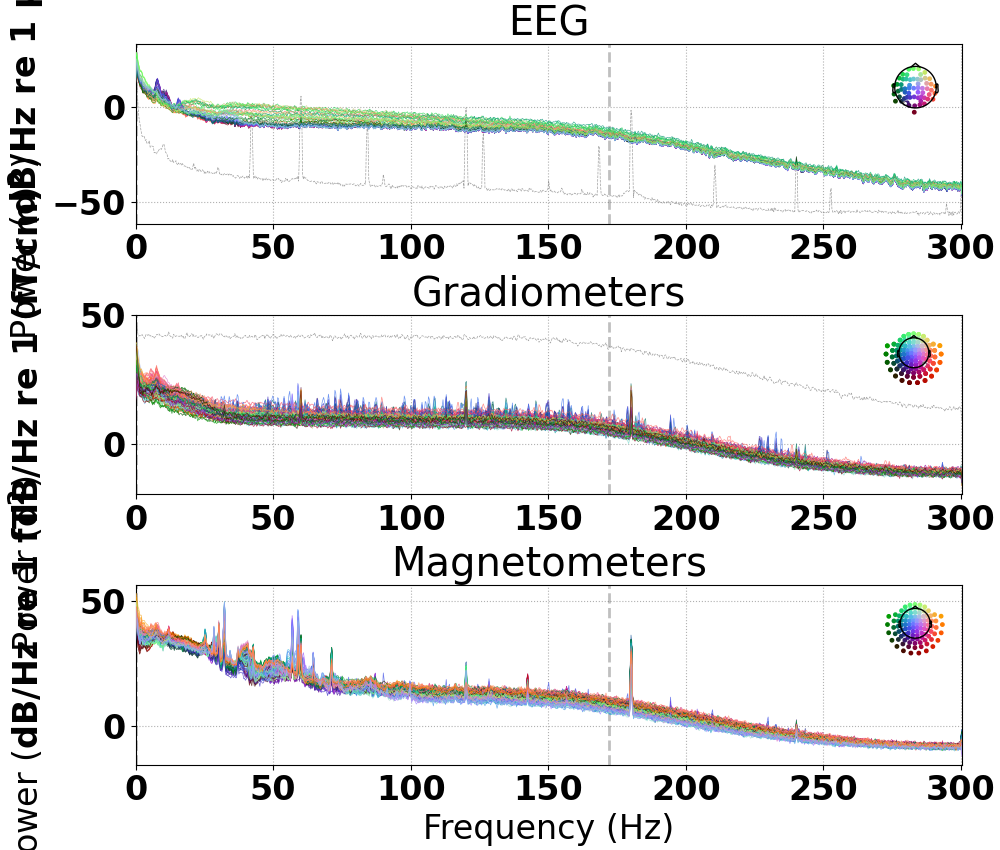

In [8]:
## PLOT POWER SPECTRAL DENSITY
fig = psd.plot() # online low-pass filter of 170 Hz

## FILTERING THE DATA

We low-pass filter the data, as we are only looking for evoked responses, which are rarely above 40 Hz

In [9]:
## FILTERING DATA WITH LOW-PASS FILTER
raw_sample.filter(l_freq=None, h_freq=40) # low-pass filter of 40 Hz

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 199 samples (0.331 s)



<Raw | sample_audvis_raw.fif, 376 x 166800 (277.7 s), ~481.7 MiB, data loaded>

Effective window size : 3.410 (s)
Plotting power spectral density (dB=True).


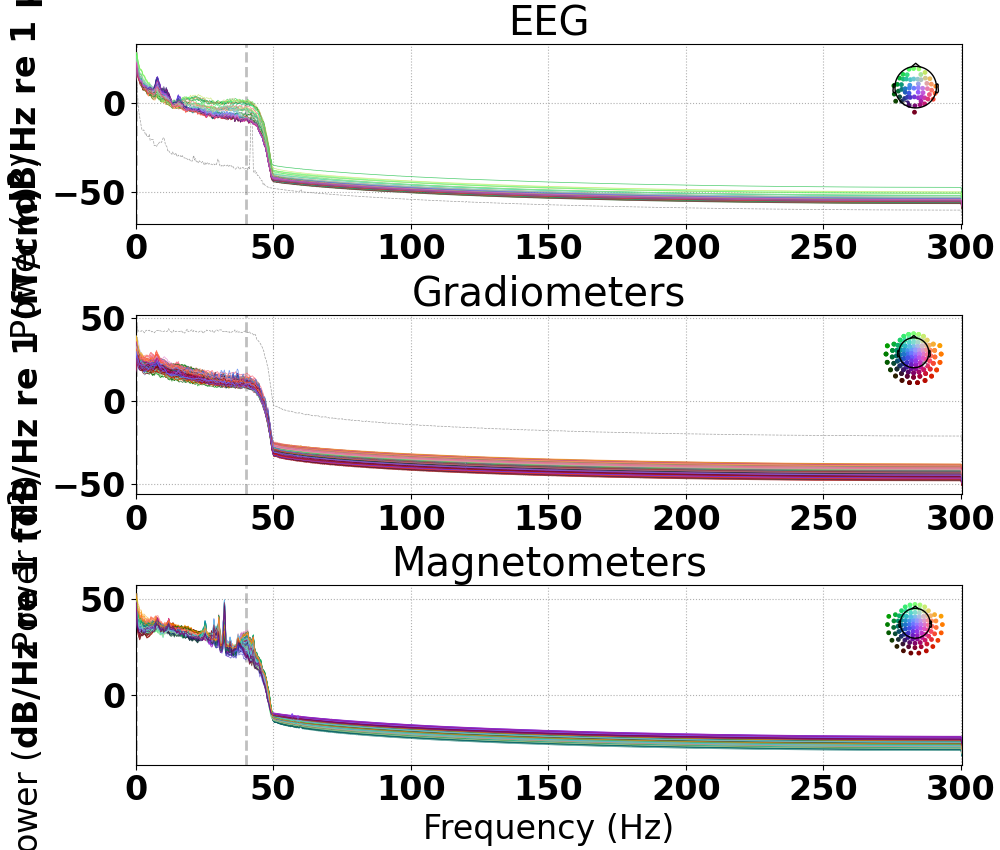

In [10]:
## PLOTTING POWER SPECTRAL DENSITY AFTER LOW-PASS FILTER
fig = raw_sample.compute_psd().plot()

## FINDING THE RELEVANT EVENTS

On the trigger channel `'STI014'`, square pulses were sent to indicate when stimuli were presented and responses were registered.
Check the `raw_sample.plot()` and see if you can find it and the square pulses

Finding events on: STI 014
320 events found on stim channel STI 014
Event IDs: [ 1  2  3  4  5 32]


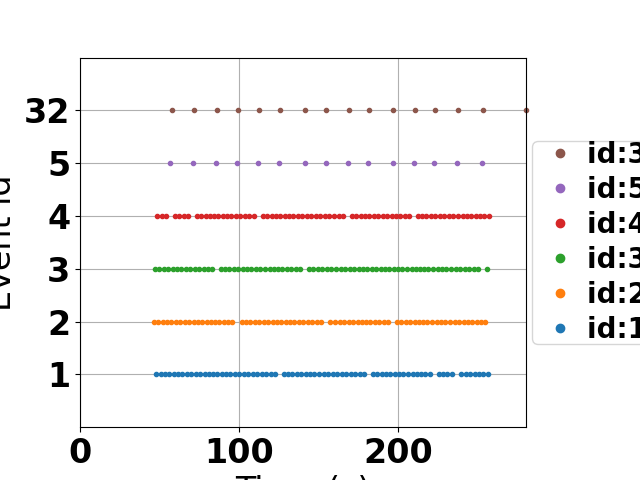

In [11]:
#%% FIND EVENTS

events_sample = mne.find_events(raw_sample)
mne.viz.plot_events(events_sample, sfreq=raw_sample.info['sfreq']);

## LA: 1: Response to left-ear auditory stimulus (a tone)
## RA: 2: Response to right-ear auditory stimulus
## LV: 3: Response to left visual field stimulus (checkerboard)
## RV: 4: Response to right visual field stimulus
## smiley: 5: Response to the smiley face
## button: 32: Response triggered by the button press
# https://mne.tools/stable/overview/datasets_index.html#sample

## SEGMENTING/EPOCHING THE DATA

Instead of handling all the data at once, we just cut out segments around the events of interest

In [12]:
#%% EPOCH THE DATA
event_id = dict(LA=1) ## we'll just look at this one event
tmin = -0.200 # s
tmax =  0.600 # s
baseline = (None, 0) # s (from beginning to 0); for demeaning

## segment the data
epochs_sample = mne.Epochs(raw_sample, events_sample,
                           event_id, tmin, tmax, baseline, preload=True)
epochs_sample.set_eeg_reference(projection=True);

Not setting metadata
72 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 3)
3 projection items activated
Using data from preloaded Raw for 72 events and 481 original time points ...
0 bad epochs dropped
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.


In [13]:
## PLOT EPOCHS
fig = epochs_sample.plot()

## AVERAGING TO OBTAIN AN EVOKED RESPONSE

To increase the signal-to-noise ratio, we average the epochs

In [14]:
#%% AVERAGE (EVOKED)
evoked_sample = epochs_sample.average()

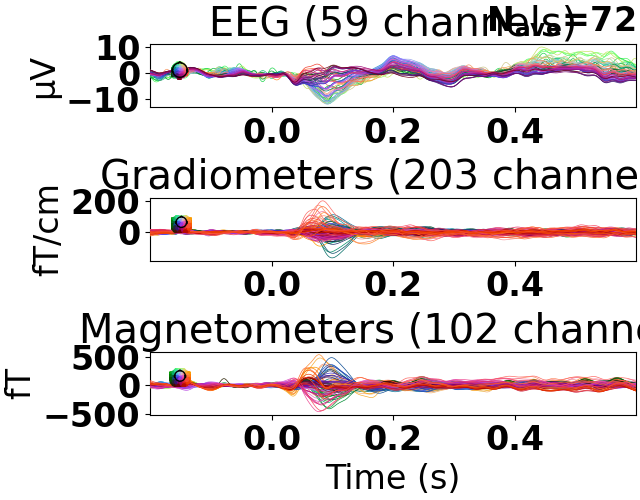

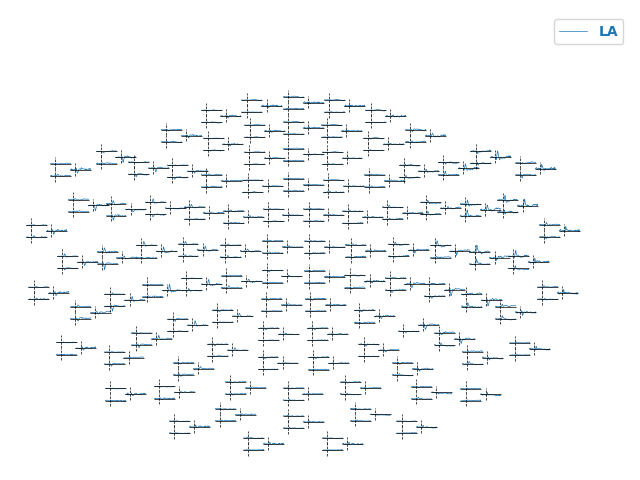

In [15]:
## PLOTTING AVERAGES
evoked_sample.plot() 
mne.viz.plot_evoked_topo(evoked_sample);

In [16]:
#%% HAVING MORE THAN ONE EVENT

event_id = dict(LA=1, RA=2, LV=3, RV=4)
more_epochs = mne.Epochs(raw_sample, events_sample,
                           event_id, tmin=-0.200, tmax=0.600,
                           baseline=(None, 0),
                           preload=True)

more_evokeds = list()
for event in more_epochs.event_id:
    more_evokeds.append(more_epochs[event].average());



Not setting metadata
289 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 3)
3 projection items activated
Using data from preloaded Raw for 289 events and 481 original time points ...
0 bad epochs dropped


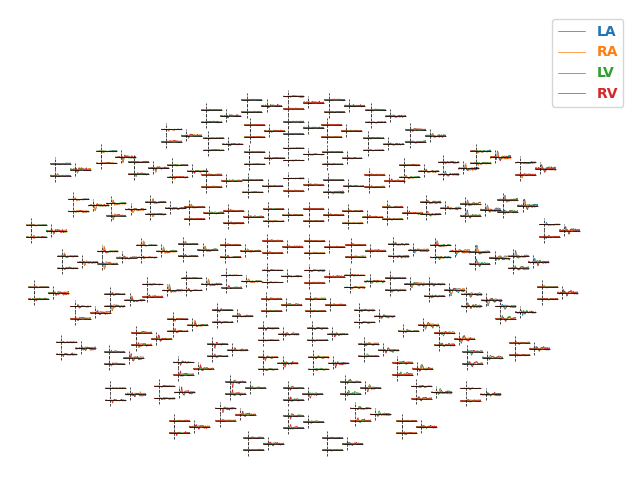

In [17]:
## PLOT SEVERAL EVENTS
mne.viz.plot_evoked_topo(more_evokeds);

## FORWARD MODEL

$\boldsymbol L (\boldsymbol r)$ is our forward model that for each source location $\boldsymbol r$, expresses how that source is linked to the sensors. The SI-unit is $\frac {T} {Am}$.  
The SI-unit for the magnetic field at each time point, $t$, $\boldsymbol b (t)$ is $T$.  
The SI-unit for the current density $\boldsymbol s(\boldsymbol r, t)$  at each location $\boldsymbol r$ and time point $t$ is $Am$.  
The forward model states for each source at whatever $\boldsymbol r$ how its activation in $Am$ is linked to the magnetic field at each sensor, e.g. $b_1(t)$.  
$\boldsymbol n(t)$ is the Gaussian noise at each time point

$\boldsymbol b(t) = \left[
\begin{array}{c} 
b_1(t) \\
b_2(t) \\
\vdots \\
b_M(t)
\end{array}
\right]$  
$\boldsymbol{b}(t) = \boldsymbol{L}(\boldsymbol{r}) \boldsymbol s(\boldsymbol r, t) + \boldsymbol n(t)$

The nice people from MNE-Python have already made a forward model for us

In [18]:
## READ FORWARD MODEL
fwd = mne.read_forward_solution('sample_audvis-meg-eeg-oct-6-fwd.fif')

Reading forward solution from /home/lau/mne_data/MNE-sample-data/MEG/sample/sample_audvis-meg-eeg-oct-6-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523 (FIFF_MNE_FORWARD_SOLUTION_GRAD)) not available
    Read MEG forward solution (7498 sources, 306 channels, free orientations)
    Desired named matrix (kind = 3523 (FIFF_MNE_FORWARD_SOLUTION_GRAD)) not available
    Read EEG forward solution (7498 sources, 60 channels, free orientations)
    Forward solutions combined: MEG, EEG
    Source spaces transformed to the forward solution coordinate frame


## PLOTTING THE FORWARD MODEL

`mne.viz.plot_alignment` does not work on UCloud

In [19]:
## PLOT SOURCE SPACE

# extract source space
src = fwd['src']
##plot alignment does not work on UCloud
#mne.viz.plot_alignment(info=epochs_sample.info, src=src, subjects_dir='../../subjects/',
 #                      subject="sample", surfaces="white", trans='sample_audvis_raw-trans.fif')

## 2D alternative

#mne.viz.plot_sensors(raw_sample.info);

In [20]:
## INFO ABOUT WHERE CHANNELS ARE (in subject's head space)
info = epochs_sample.info
print(info['chs'][2]['loc'])

[-0.1066      0.0464     -0.0604     -0.0127      0.0057     -0.99990302
 -0.186801   -0.98240298 -0.0033     -0.98232698  0.18674099  0.013541  ]


In [21]:
## INFO ABOUT WHERE SOURCE ARE (in subject's MR space)
src = fwd['src']
# src = mne.source_space.setup_source_space(subject='sample', subjects_dir=subjects_dir)
print(fwd['src'][0]['rr'])

[[-0.0254402  -0.05578539  0.08920044]
 [-0.02560006 -0.05570197  0.08922538]
 [-0.02589042 -0.05552552  0.08917718]
 ...
 [-0.01673571  0.0979876   0.03121898]
 [-0.01849602  0.09840199  0.03267473]
 [-0.01929106  0.09814776  0.03184829]]


In [22]:
## TRANSFORMATION MATRIX THAT MAPS THE TWO SPACES ONTO ANOTHER
trans = mne.read_trans('sample_audvis_raw-trans.fif')
print(trans)

<Transform | head->MRI (surface RAS)>
[[ 0.99930954  0.01275934  0.0348942   0.00206991]
 [ 0.00998479  0.81240475 -0.58300853  0.01130214]
 [-0.03578702  0.58295429  0.81171638 -0.02755522]
 [ 0.          0.          0.          1.        ]]


In [23]:
## BOUNDARY ELEMENT METHOD

## describe the surfaces and their conductivities
#bem_model = mne.bem.make_bem_model(subject=subject, subjects_dir=subjects_dir,
#                           conductivity=[0.3, 0.006, 0.3]) ## three layer model

## model how electrical potentials spread to the electrodes and how the 
# currents of the brain are related to the magnetic field measured at the
# sensors
#bem_solution = mne.bem.make_bem_solution(bem_model)

bem_solution = mne.bem.read_bem_solution('../../subjects/sample/bem/sample-5120-5120-5120-bem-sol.fif')

print(bem_solution['solution'])

Loading surfaces...

Loading the solution matrix...

Three-layer model surfaces loaded.
Loaded linear collocation BEM solution from /home/lau/mne_data/MNE-sample-data/MEG/sample/../../subjects/sample/bem/sample-5120-5120-5120-bem-sol.fif
[[ 2.1514516e-02 -1.8183291e-05 -1.6480033e-05 ... -5.9466978e-04
  -6.6832255e-04 -8.1568857e-04]
 [-1.1894640e-05  2.0677185e-02 -9.1299444e-06 ... -4.5286494e-04
  -3.5304064e-04 -4.2359543e-04]
 [-1.7444265e-05 -1.4329190e-05  2.0779889e-02 ... -3.9645983e-04
  -4.3777065e-04 -3.9654653e-04]
 ...
 [-7.9648926e-06  5.6645104e-07 -1.5632158e-06 ...  1.0602014e+00
   3.4819089e-02  3.0055961e-02]
 [-8.0139662e-06  3.6772704e-07 -1.5281699e-06 ...  3.3850696e-02
   1.0879593e+00  3.0417060e-02]
 [-8.5733745e-06  1.1546878e-09 -1.7350318e-06 ...  2.7086738e-02
   2.7894983e-02  1.1020797e+00]]


In [24]:
## create a forward solution using four ingredients; L(r),
# which maps how sources in the brain link to sensors in the helmet:
# info: information about channel positions and sensor types
# trans: the transformation needed to align channel positions with MR
# src: the source model (in this case, a cortical sheet)
# bem_solution: modelling of how electrical currents spread toward the
#               electrodes   

#fwd = mne.make_forward_solution(info=info, trans=trans, src=src, bem=bem_solution)

## FINALLY DO THE MINIMUM NORM ESTIMATE

$$
\huge \hat{\boldsymbol \nu}_{vox}(t) = \boldsymbol L_V^T(\boldsymbol G + \epsilon \boldsymbol I)^{-1} \boldsymbol b(t)    
$$
with
$$
\huge \boldsymbol G = \int_\Omega \boldsymbol L (\boldsymbol r) \boldsymbol L^T (\boldsymbol r) d^3r
$$
and with
$$ 
\huge
\boldsymbol{\hat{\nu}}_{vox}(t) = \left[
\begin{array}{c} 
\boldsymbol{\hat s} (\boldsymbol r_1, t) \\
\boldsymbol{\hat s} (\boldsymbol r_2, t) \\
\vdots \\
\boldsymbol{\hat s} (\boldsymbol r_N, t)
\end{array}
\right]  
$$


In [ ]:
##  used to whiten the data, i.e. normalizing magnetometers, gradiometers
## and electrode readings to make them comparable
noise_cov = mne.compute_covariance(epochs_sample, tmin=None, tmax=0)
noise_cov.plot(raw_sample.info)

    Created an SSP operator (subspace dimension = 4)
    Setting small MEG eigenvalues to zero (without PCA)
    Setting small EEG eigenvalues to zero (without PCA)
Reducing data rank from 364 -> 360
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 8712
[done]


In [ ]:
inverse_operator = mne.minimum_norm.make_inverse_operator(epochs_sample.info, fwd,
                                                          noise_cov)

# estimating the source pattern for each time point Vvox(t)
# right auditory stimulus (evokeds_sample[1])
MNE = mne.minimum_norm.apply_inverse(evoked_sample, inverse_operator,
                                     method='MNE')
## standard is to use method=dSPM for depth correction

In [ ]:
MNE.plot(subject='sample', subjects_dir=subjects_dir, hemi='both') ## can only be done locally